In [286]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Delaunay

## Define Functions

In [287]:
# Helper function to rotate feature kernel
def rotate_point(origin, point, angle):

    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)

    return int(qx), int(qy)

# Node detection kernel, generates feature to detect inside sliding window
def generate_features(win, feature, angle=0, thickness=1):

    # Check that feature is correctly specified
    assert feature in ("cross", "tee", "elbow", "end"), "Feature must be one of 'cross', 'tee', 'elbow', or 'end'."

    # Convert angle to radians
    angle = np.deg2rad(angle)
    
    # Create kernel matrix, if end feature is selected, generate end-detector mask
    kernel = np.zeros((win, win), np.uint8)
    if feature == "end":
        end_mask = np.zeros((win, win), np.uint8)

    # Define center of kernel
    center = win // 2
    origin = (center, center)

    # Draw Top
    if feature in ("cross", "tee", "end"):
        endpoint = rotate_point(origin, (center, -10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness=1)
    # Draw Bottom
    if feature == "cross":
        endpoint = rotate_point(origin, (center, win-10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness=1)
    # Draw Left 
    if feature in ("cross", "tee"):
        endpoint = rotate_point(origin, (-10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness=1)
    # Draw Right 
    if feature in ("cross", "tee", "elbow"):
        endpoint = rotate_point(origin, (win-10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness=1)
    # Draw end mask, if applicable
    if feature == "end":
        edge_detector_1 = rotate_point(origin, (center-win//4, center), angle)
        edge_detector_2 = rotate_point(origin, (center+win//4, center), angle)
        edge_detector_3 = rotate_point(origin, (center, win-win//3+1), angle)
        cv2.line(end_mask, edge_detector_1, edge_detector_1, (1, 1, 1), thickness)
        cv2.line(end_mask, edge_detector_2, edge_detector_2, (1, 1, 1), thickness)
        cv2.line(end_mask, edge_detector_3, edge_detector_3, (1, 1, 1), thickness)
        end_mask = end_mask + kernel
        #cv2.line(end_mask, origin, origin, (0, 0, 0), 1) # Black out center

    if feature == "end":
        return kernel, end_mask
    else:
        return kernel

# Sliding window traverses image and checks for features
def find_vertices(img, kernel, feat, stride, deg_ii, thickness):

    # Make sure kernel has a center point
    assert kernel % 2 != 0, "Window size must be odd."

    # If image isn't grayscale, convert
    if len(img.shape) != 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold image
    _, img = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
    img = img.astype(float)//255

    # Pad image to be divisible by stride
    while img.shape[0] % stride != 0:
        img = cv2.copyMakeBorder(img, 0, 1, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    while img.shape[1] % stride != 0:
        img = cv2.copyMakeBorder(img, 0, 0, 0, 1, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Padding for sliding window
    pad = int(kernel//2)+1
    img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    # Prserved image for output and image to show hits
    img_copy = img.copy()
    detector_img = img.copy()

    # Border image to show hit window perimeter
    hit_perim = np.zeros((window, window), np.uint8)
    hit_perim[0,:] = 1 # Top
    hit_perim[:,0] = 1 # Left
    hit_perim[window-1,:] = 1 # Bottom
    hit_perim[:,window-1] = 1 # Right

    #Compute total strides
    x_strides = int(img.shape[1]/stride) - 2*pad
    y_strides = int(img.shape[0]/stride) - 2*pad
    print(f"x strides:{x_strides}, y strides:{y_strides}")

    # Initialize variables
    knots = []
    ends = []
    win_x_beg = 0
    win_y_beg = 0
    win_x_end = kernel
    win_y_end = kernel

    # Generate features to search for
    features = []
    for theta in range(0, 360, deg_ii):
        end_seg, end_mask = generate_features(window, feature="end", angle=theta, thickness=thickness)
        features.append([end_seg, end_mask])

    for ii in range(x_strides):
        for jj in range(y_strides):

            # Define current window
            cur_window = img[win_x_beg:win_x_end, win_y_beg:win_y_end]
            
            # If window has been marked by a previous positive hit (has a nan) then skip.
            if np.isnan(cur_window).any():
                break
            elif np.sum(cur_window) == 0:
                break
            else:
                
                # Only look in windows that aren't black, and aren't too white
                if feat != "end" and np.mean(cur_window) < .4:
                    
                    # If window qualifies, rotate the search feature and check if it is present.
                    for feature in features:
                        if np.array_equal((feature*cur_window), feature):
                            knots.append((win_y_beg+pad, win_x_beg+pad))
                            # If feature is found, fill window with gray as a debounce
                            img[win_x_beg:win_x_end, win_y_beg:win_y_end] = np.nan
                            detector_img[win_x_beg:win_x_end, win_y_beg:win_y_end] = feature
                            break
                        
                # End features use a mask to confirm that a detected line isn't continuous              
                elif np.mean(cur_window) < .4:
                    
                    # If window qualifies, rotate the search feature and check if it is present.
                    for feature in features:
                        end_segment = feature[0]
                        end_detector = feature[1]
                        compare = end_detector * cur_window
                        if np.array_equal(compare, end_segment):
                            ends.append((win_y_beg+pad, win_x_beg+pad))
                            # Annotate image with feature detected and window it was found in
                            detector_img[win_x_beg:win_x_end, win_y_beg:win_y_end] = end_detector*2 + cur_window*.25 + hit_perim
                            # If feature is found, fill window with white as a debounce
                            img[win_x_beg:win_x_end, win_y_beg:win_y_end] = np.nan
                            
                            break
                        
            
            # Increment row
            win_y_beg += stride
            win_y_end += stride
        
        # Increment column
        win_x_beg += stride
        win_x_end += stride

        # Reset row values
        win_y_beg = 0
        win_y_end = kernel

        # Image of detected ends
        detector_img

    return img_copy, knots, ends, end_segment, end_detector, detector_img

## Analyze Single Image

In [288]:
# Load image to analyze
src = cv2.imread('test_sequence/image2.png', cv2.IMREAD_GRAYSCALE)

In [289]:
# Sliding window and feature parameters
window = 17
stride = 1
feature = "end"
deg_increment = 10
detector_radius = 3

In [290]:
# Find vertices in image
resized_img, vertices, ends, end_segment, end_detector, detector_img = find_vertices(src, window, feature, stride, deg_increment, detector_radius)
print(f"image size: {resized_img.shape}")
print(f"knots detected: {len(vertices)}")
print(f"ends detected: {len(ends)}")

x strides:2042, y strides:2044
image size: (2062, 2060)
knots detected: 0
ends detected: 49


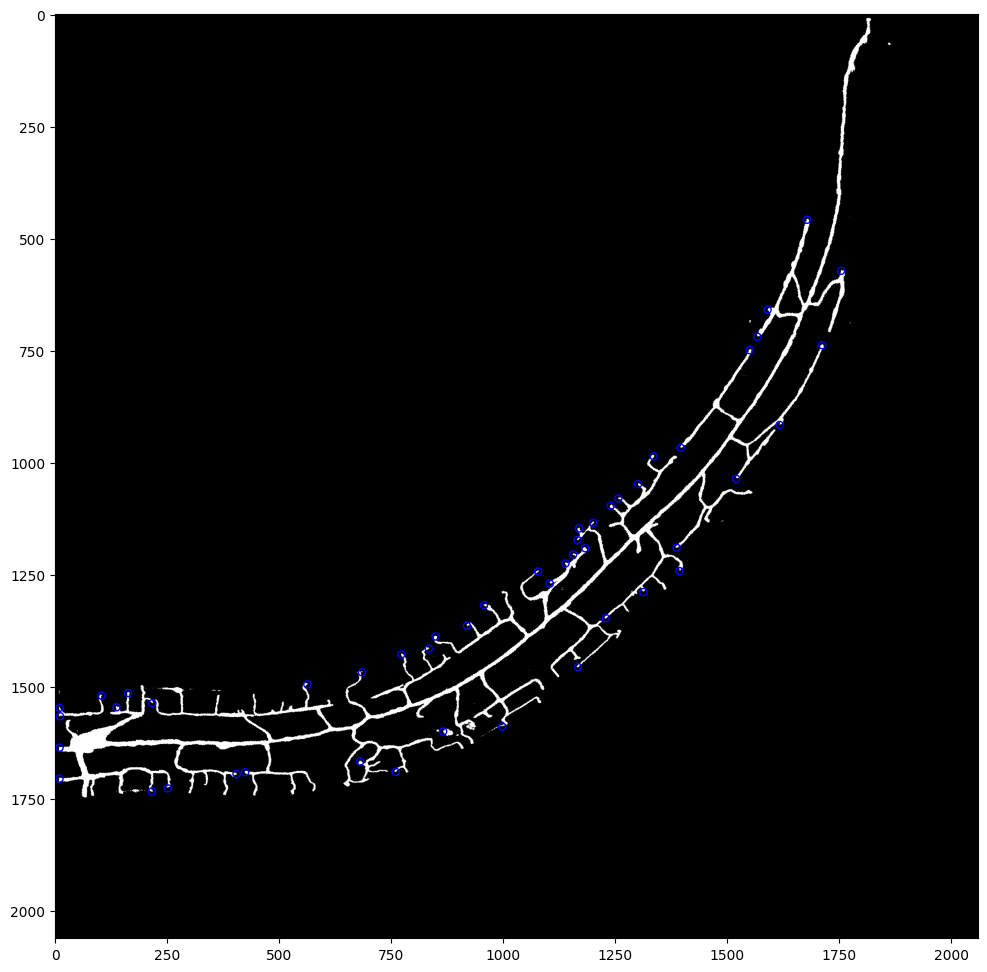

In [291]:
# Plot Vertices on image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(resized_img, cmap='gray')
#ax.scatter(*zip(*vertices), s=25, c='r', alpha=0.5)

# Adding circles at each knot
for xi, yi in vertices:
    circle = Circle((xi, yi), radius=(window//2), fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(circle)

# Adding circles at each end
for xi, yi in ends:
    circle = Circle((xi, yi), radius=(window//2), fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(circle)

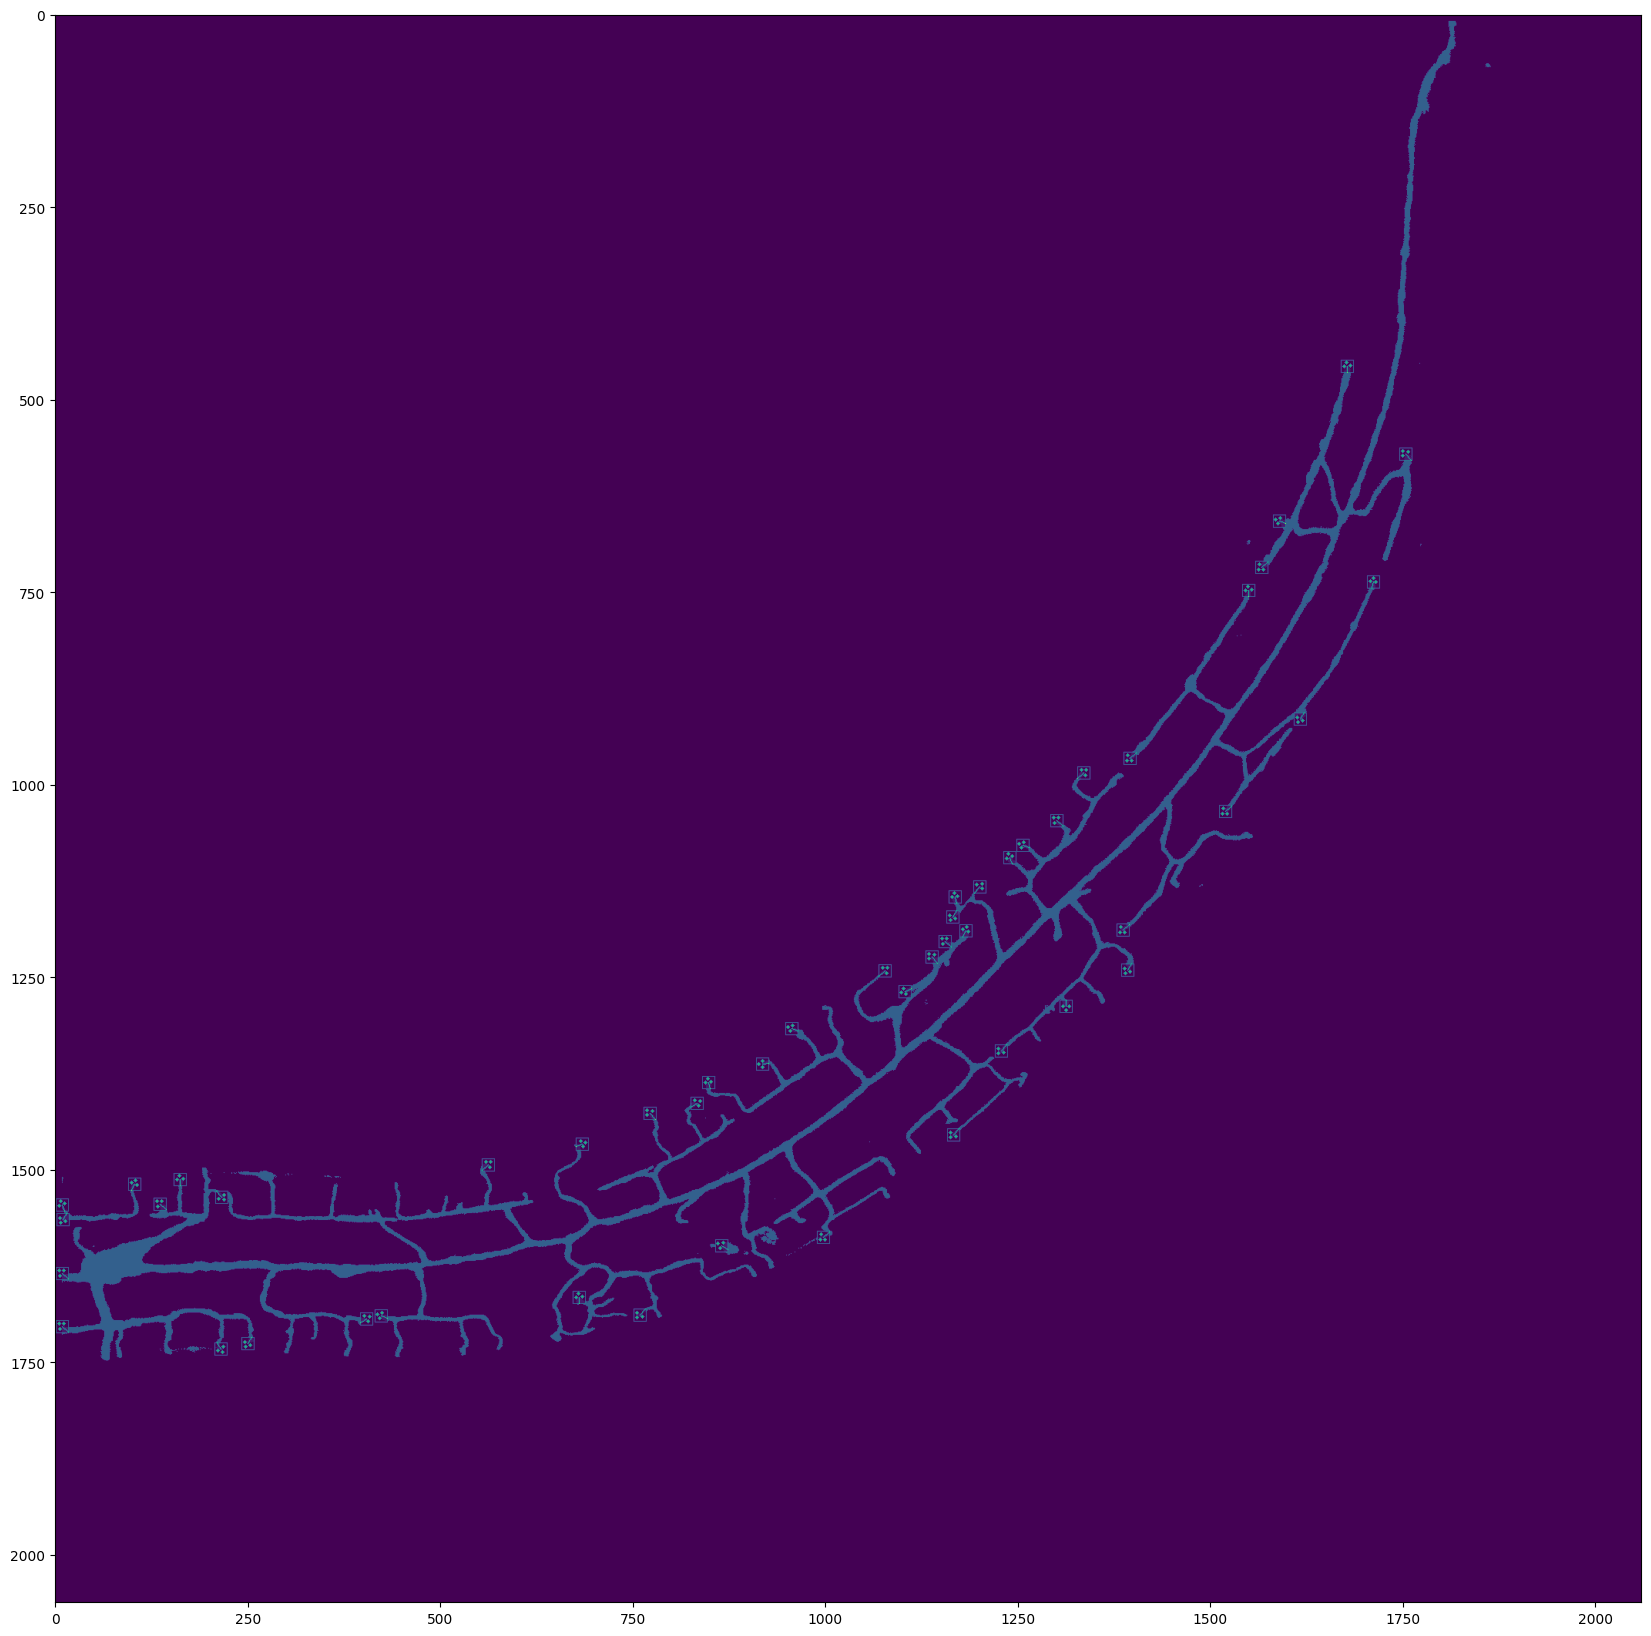

In [292]:
# Plot Vertices on image
fig, ax = plt.subplots(figsize=(detector_img.shape[0]/100, detector_img.shape[0]/100))
ax.imshow(detector_img)